# Pipeline

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import time
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

# paths
ROOT_PATH = Path('/home/downloads/carnd-p5-vehicle-detection')

## Utilities

In [66]:
def convert_color_rgb(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'LAB':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        cvt_image = np.copy(image)
    
    return cvt_image



def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [127]:
def extract_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    hog_features = hog(img, orientations=orient, 
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                visualize=False, feature_vector=feature_vec, block_norm='L1')
    return hog_features

def extract_features(image, cspace='RGB', orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel='ALL'):
    feature_image = convert_color_rgb(image, cspace)
    
    if hog_channel == 'ALL':
        hog_features = []
        for ch in range(feature_image.shape[2]):
            hog_features_ch = extract_hog_features(feature_image[:, :, ch], orient, pix_per_cell, cell_per_block, feature_vec=True)
            hog_features.append(hog_features_ch)
        hog_features = np.ravel(hog_features)

    else:
        hog_features = extract_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, feature_vec=True)
        
    return hog_features

## Training a classifier

In [128]:
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [129]:
#CAR_IMAGES_PATH = ROOT_PATH/'data/vehicles/KITTI_extracted'
CAR_IMAGES_PATH = ROOT_PATH/'data/vehicles/all'

NOTCAR_IMAGES_PATH = ROOT_PATH/'data/non-vehicles/GTI'
NOTCAR_IMAGES2_PATH = ROOT_PATH/'data/non-vehicles/Extras'

print('Total car images: ', len(list(CAR_IMAGES_PATH.iterdir())))
print('Not car images: ', len(list(NOTCAR_IMAGES_PATH.iterdir())))
print('Not car images: ', len(list(NOTCAR_IMAGES2_PATH.iterdir())))

Total car images:  6920
Not car images:  3902
Not car images:  5069


car features...
car_features length:  6920


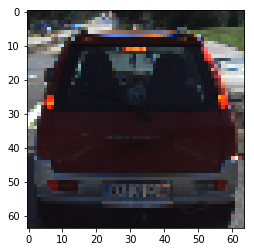

notcar features...
notcar_features length:  8968


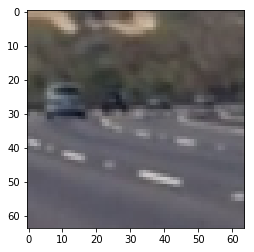

CPU times: user 34.7 s, sys: 567 ms, total: 35.3 s
Wall time: 34.9 s


In [130]:
%%time
SAMPLE_RATIO = 1

car_features = []
print('car features...')
car_files = list(CAR_IMAGES_PATH.glob('*png'))
for file in np.array(car_files):
    img = plt.imread((file.as_posix()))
    features =  extract_features(img, cspace=cspace, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    car_features.append(features)
print('car_features length: ', len(car_features))
plt.imshow(img)
plt.show()

print('notcar features...')
notcar_features = []
noncar_files = list(NOTCAR_IMAGES_PATH.glob('*png')) + list(NOTCAR_IMAGES2_PATH.glob('*png'))
for file in np.array(noncar_files):
    img = plt.imread(file.as_posix())
    features =  extract_features(img, cspace=cspace, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features.append(features)
print('notcar_features length: ', len(notcar_features))
plt.imshow(img)
plt.show()

In [131]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('Shape of X: ', X.shape)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Shape of y: ', y.shape)

Shape of X:  (15888, 1188)
Shape of y:  (15888,)


Random split

In [132]:
rand_state = 12
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X_train)
#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

Training

In [133]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(random_state=rand_state)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
#print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
1.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9833
5e-05 Seconds to predict 100 labels with SVC


In [134]:
#svc = pickle.load(open(ROOT_PATH/'models/svc_ver1.pkl', 'rb'))

## Subsampling with multiple windows

In [148]:
def search_windows_with_scale(img, scale, cells_per_step, ystart, ystop, xstart, xstop, classifier, 
                              scaler, cspace, orient, pix_per_cell, cell_per_block):
    hot_windows = []
    img = img.astype(np.float32)/255
    
    # crate an empty list to receive positive detection windows
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color_rgb(img_tosearch, cspace=cspace)
    #print('before: ', ctrans_tosearch.shape)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #print('after: ', ctrans_tosearch.shape)
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window_size = 64
    nblocks_per_window = (window_size // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    #hog = extract_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = extract_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = extract_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = extract_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = classifier.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window_size*scale)
                hot_window = ((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart))
                hot_windows.append(hot_window)
                
    return hot_windows

In [149]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


1 rectangles found in image
Number of boxes:  1


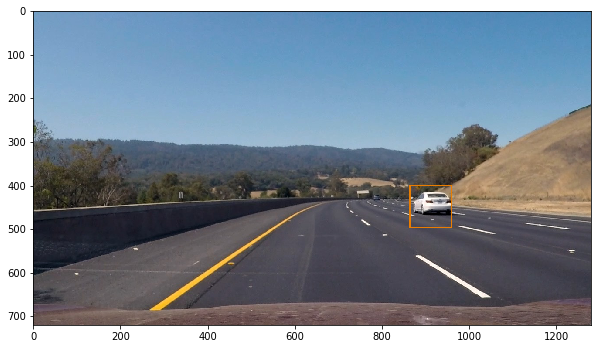

In [150]:
test_img = plt.imread('../images/test_images/test3.jpg')

ystart = 400
ystop = 656
scale = 1.5
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
cells_per_step=2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = search_windows_with_scale(test_img, scale, cells_per_step, ystart, ystop,
                                       0, 1280, svc, None, cspace, orient, pix_per_cell, cell_per_block)
print(len(rectangles), 'rectangles found in image')
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

In [151]:
class CarDetector():
    def __init__(self, scales, threshold, classifier, scaler, cspace, 
                 orient, pix_per_cell, cell_per_block, num_records=10, diagnosis=False):
        self.scales = scales
        #self.windows_list = windows_list
        self.threshold = threshold
        
        self.classifier = classifier
        self.scaler = scaler
        
        self.cspace = cspace
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.diagnosis = diagnosis
        
        # store the heatmaps 
        self.heatmap_list = deque(maxlen=num_records)
    
    def detect(self, img):
        # create an empty array to store heatmaps
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        for scale, cells_per_step, ystart, ystop, xstart, xstop in self.scales:
            hot_windows = search_windows_with_scale(img, scale, cells_per_step, ystart, ystop, xstart, xstop, 
                                                    self.classifier, self.scaler, self.cspace, self.orient, 
                                                    self.pix_per_cell, self.cell_per_block)
            heat = add_heat(heat, hot_windows)

        return heat
        
    def apply_thresh_on_sum(self, heat):
        self.heatmap_list.append(heat)
        heatmap = np.sum(np.array(self.heatmap_list), axis=0)
        if self.diagnosis:
            fig, axes = plt.subplots(1, 2, figsize=(12, 9))
            axes[0].imshow(heat, cmap='hot')
            heatmap = apply_threshold(heatmap, self.threshold)
            axes[1].imshow(heatmap, cmap='hot')
            plt.show()
        else:
            heatmap = apply_threshold(heatmap, self.threshold)
        heatmap = np.clip(heatmap, 0, 255)
        
        labels = label(heatmap)
        
        return labels 
    
    def process(self, img):
        heat = self.detect(img)
        labels = self.apply_thresh_on_sum(heat)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        return draw_img
    
    def draw_detect_boxes(self, img, color=(0, 255, 0), thick=6):
        fig, axes = plt.subplots(np.int(np.ceil(len(self.scales)/3)), 3, figsize=(24, 6*np.int(len(self.scales)//3)))
        axes = axes.ravel()
        
        # remove empty axes
        empty_axes = axes[len(self.scales):]
        for empty_ax in empty_axes:
            fig.delaxes(empty_ax)
            
        for i, scale_info in enumerate(self.scales):
            scale, cells_per_step, ystart, ystop, xstart, xstop = scale_info
            hot_windows = search_windows_with_scale(img, scale, cells_per_step, ystart, ystop, xstart, xstop,
                                                    self.classifier, self.scaler, self.cspace, self.orient, 
                                                    self.pix_per_cell, self.cell_per_block)
            img_copy = np.copy(img)
            for w in hot_windows:
                cv2.rectangle(img_copy, w[0], w[1], color, thick)
                cv2.line(img_copy, (0, ystart), (img.shape[1], ystart), (240,230,140), 2)
                cv2.line(img_copy, (0, ystop), (img.shape[1], ystop), (240,230,140), 2)
            axes[i].set_title(scale_info)
            axes[i].imshow(img_copy)
        
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.show()
        
        heat = self.detect(img_copy)
        heatmap = apply_threshold(heat, self.threshold)
        plt.imshow(heatmap, cmap='hot')
        plt.show()              

### Tuning scales

In [152]:
test_image_path = ROOT_PATH/'images/test_images/test3.jpg'
test_image = plt.imread(test_image_path.as_posix())

In [153]:
scales = [(1+x*0.1, 1, 395, 656, 0, 1280) for x in range(6)]

threshold = 10
car_detector = CarDetector(scales, threshold, classifier=svc, scaler=None, cspace=cspace, orient=orient,
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, diagnosis=False)

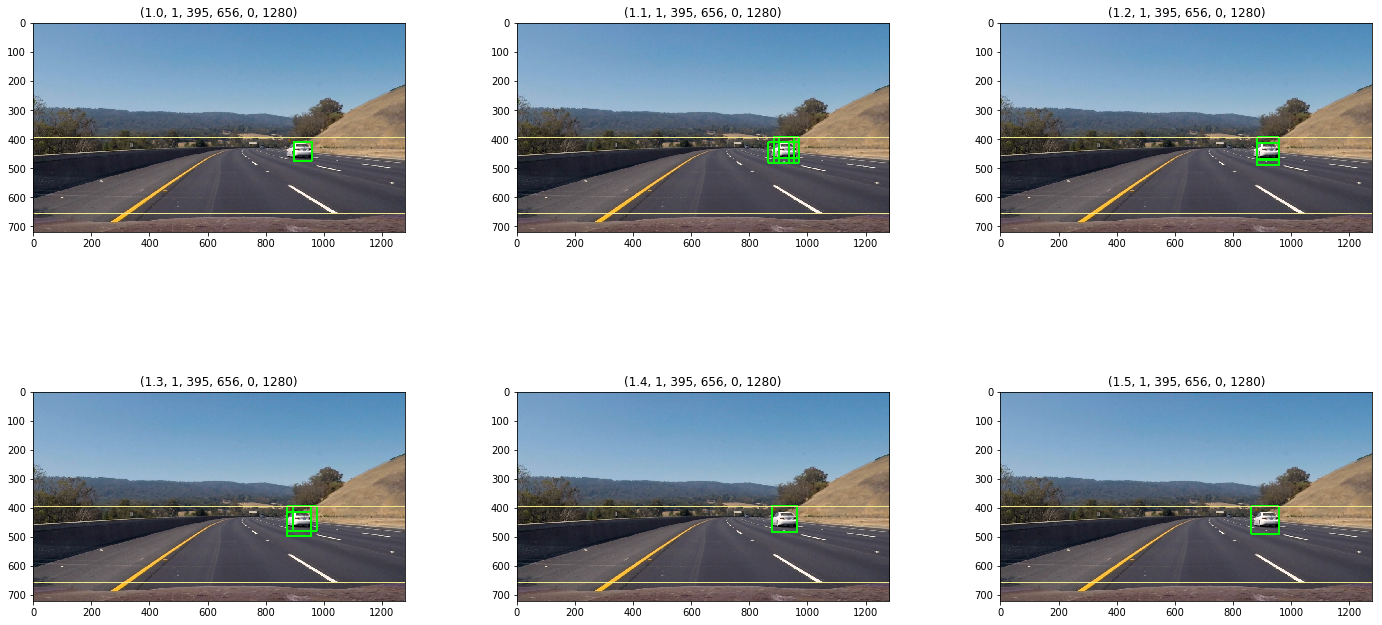

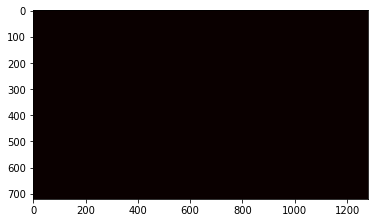

CPU times: user 3.01 s, sys: 1.08 s, total: 4.1 s
Wall time: 2.79 s


In [154]:
%%time
car_detector.draw_detect_boxes(test_image)

### Test on Test Images

In [159]:
scales = [
    #(0.6, 1, 395, 500, 800, 1280),
    #(0.78, 1, 395, 500, 800, 1280),
    #(0.78,  1, 395, 500, 400, 1280), 
    #(0.82,  1, 395, 500, 400, 1280),
    #(1,    1, 395, 560, 500, 1280),
    (1, 2, 400, 512, 450, 1280),
    (1, 2, 416, 528, 450, 1280),
    (1.12, 2, 400, 544, 400, 1280),
    (1.12, 2, 416, 528, 400, 1280),
    (1.5,  2, 400, 528, 300, 1280),
    (1.5,  2, 416, 544, 300, 1280),
    #(1.6, 1, 400, 600,  100, 1280),
    #(1.8, 1, 400, 650,  0, 1280),
    #(1.75, 1, 395, 600),
    #(2.06, 1, 395, 680, 200, 1280),
    #(2.25, 3, 395, 600),
    (2.5, 2, 400, 576, 400, 1280),
    (2.5, 2, 416, 592, 400, 1280),
    #(2.7,  6, 385, 630),
]


threshold = 2
car_detector = CarDetector(scales, threshold, classifier=svc, scaler=None, cspace=cspace, orient=orient,
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, diagnosis=False)

/home/downloads/carnd-p5-vehicle-detection/images/test_images/test4.jpg


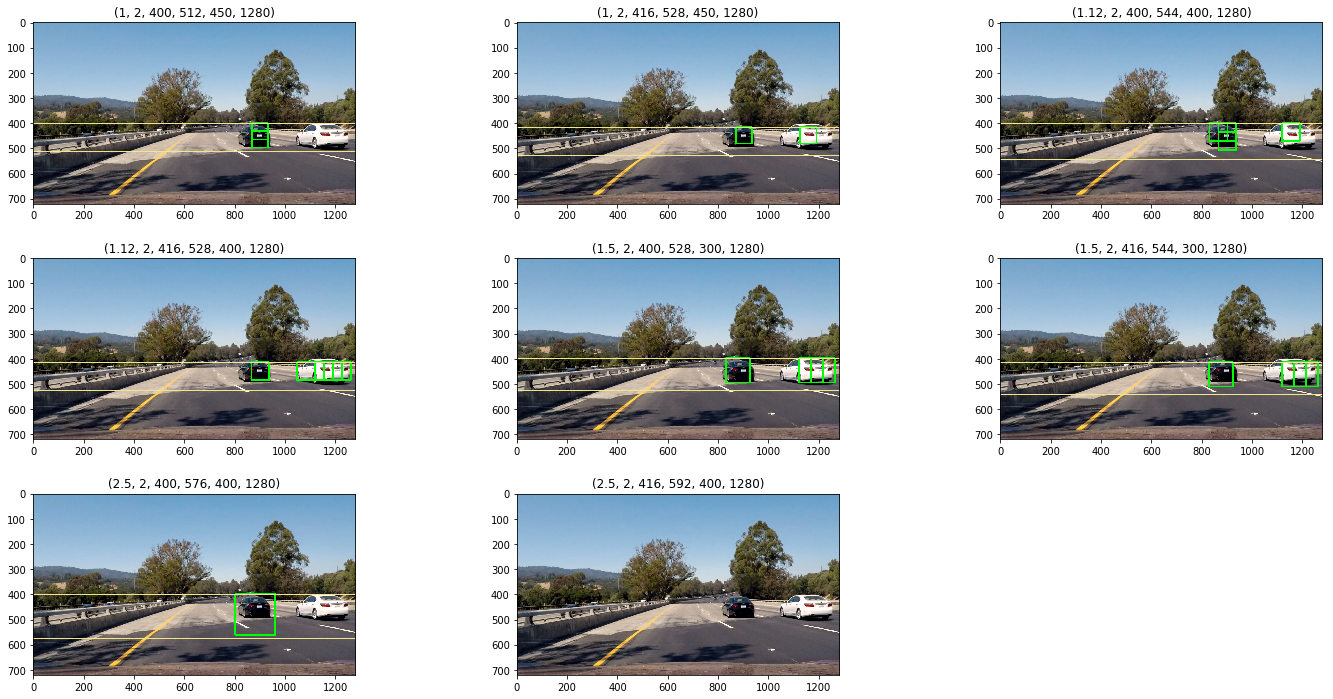

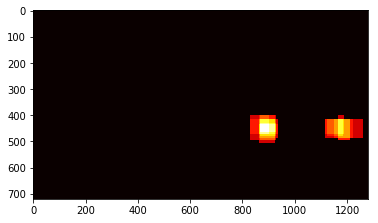

CPU times: user 2.18 s, sys: 1.23 s, total: 3.41 s
Wall time: 2.01 s
/home/downloads/carnd-p5-vehicle-detection/images/test_images/test3.jpg


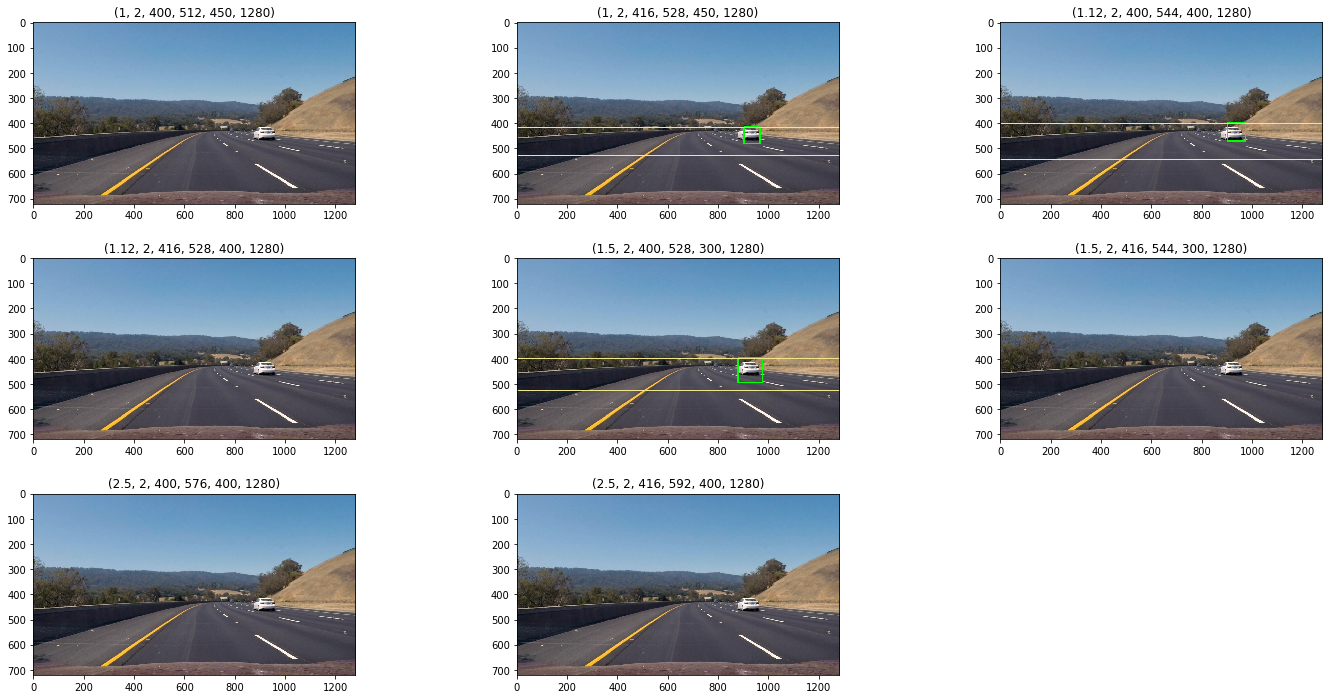

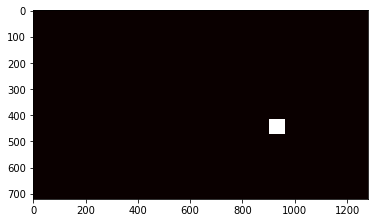

CPU times: user 2.17 s, sys: 1.24 s, total: 3.41 s
Wall time: 1.93 s
/home/downloads/carnd-p5-vehicle-detection/images/test_images/test1.jpg


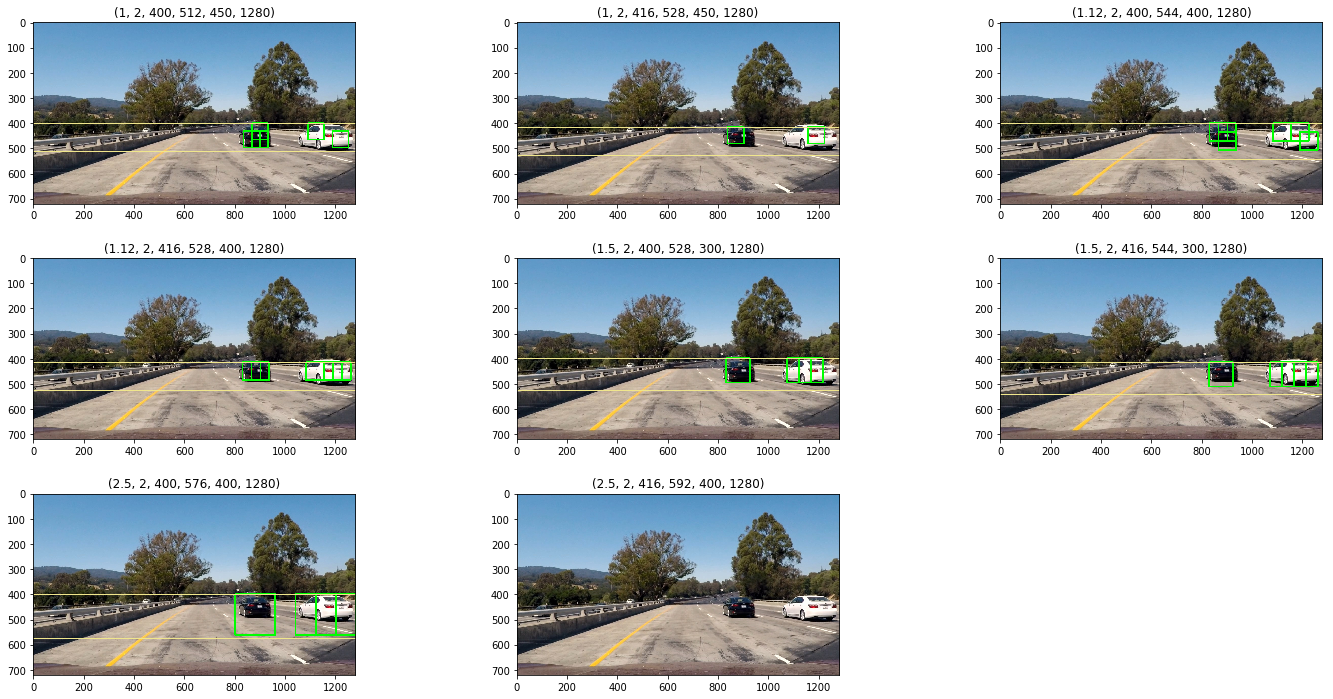

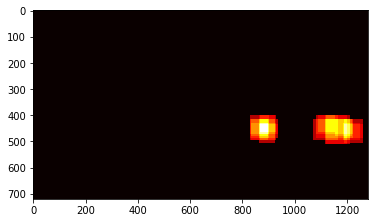

CPU times: user 2.07 s, sys: 1.28 s, total: 3.35 s
Wall time: 1.91 s
/home/downloads/carnd-p5-vehicle-detection/images/test_images/test6.jpg


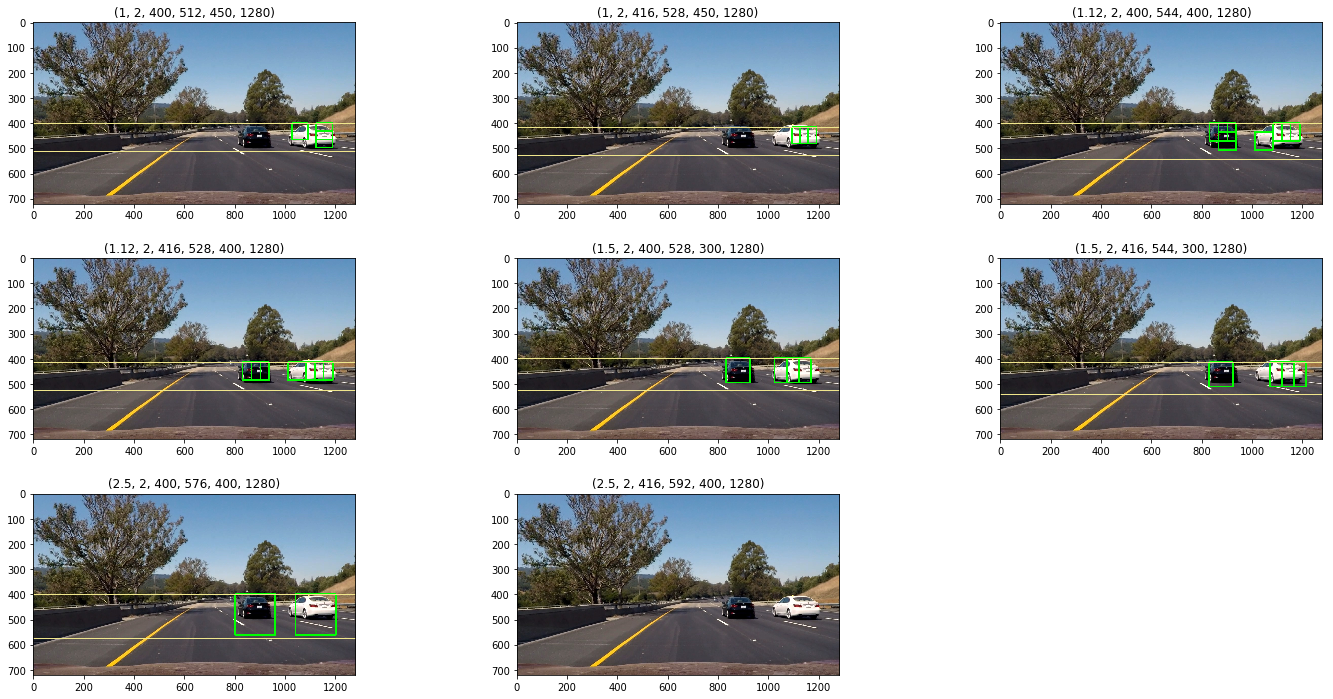

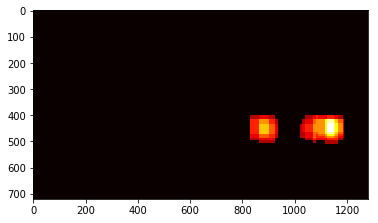

CPU times: user 2.17 s, sys: 1.25 s, total: 3.42 s
Wall time: 1.97 s
/home/downloads/carnd-p5-vehicle-detection/images/test_images/test2.jpg


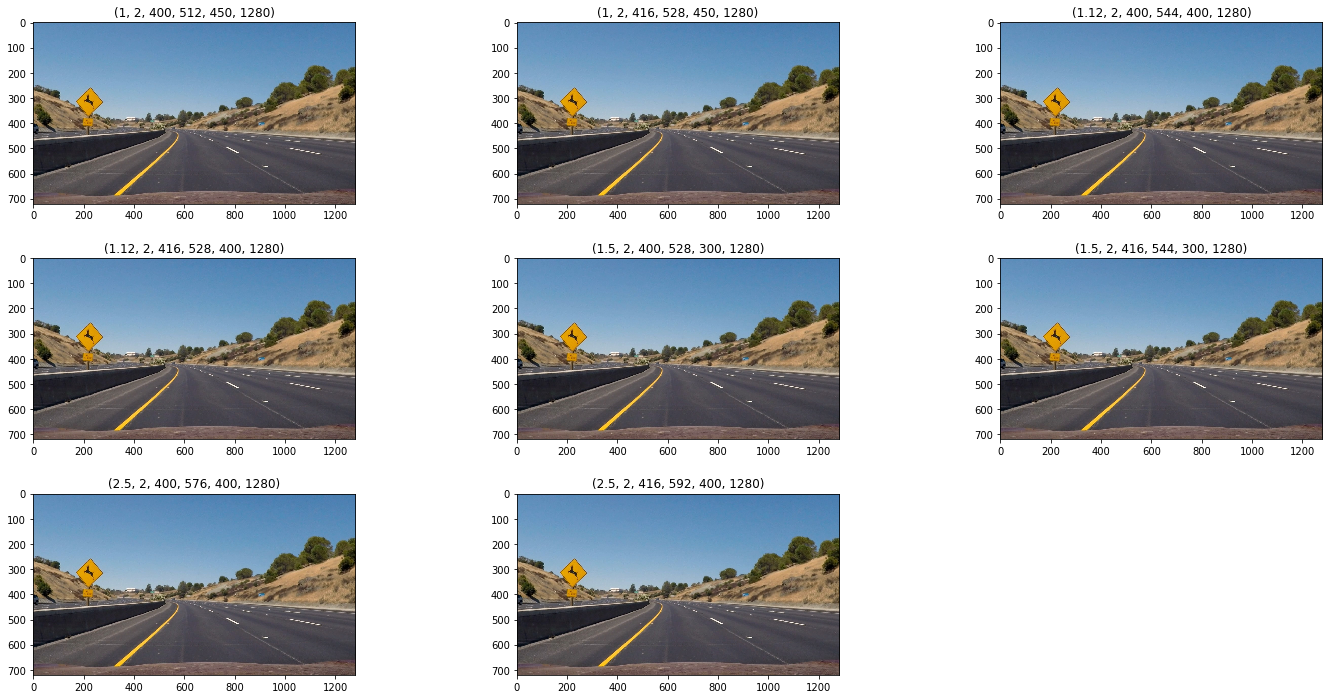

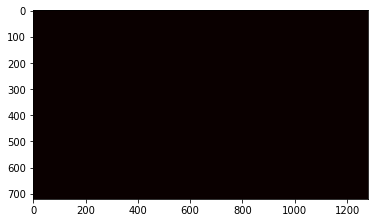

CPU times: user 2.13 s, sys: 1.3 s, total: 3.44 s
Wall time: 1.95 s
/home/downloads/carnd-p5-vehicle-detection/images/test_images/test5.jpg


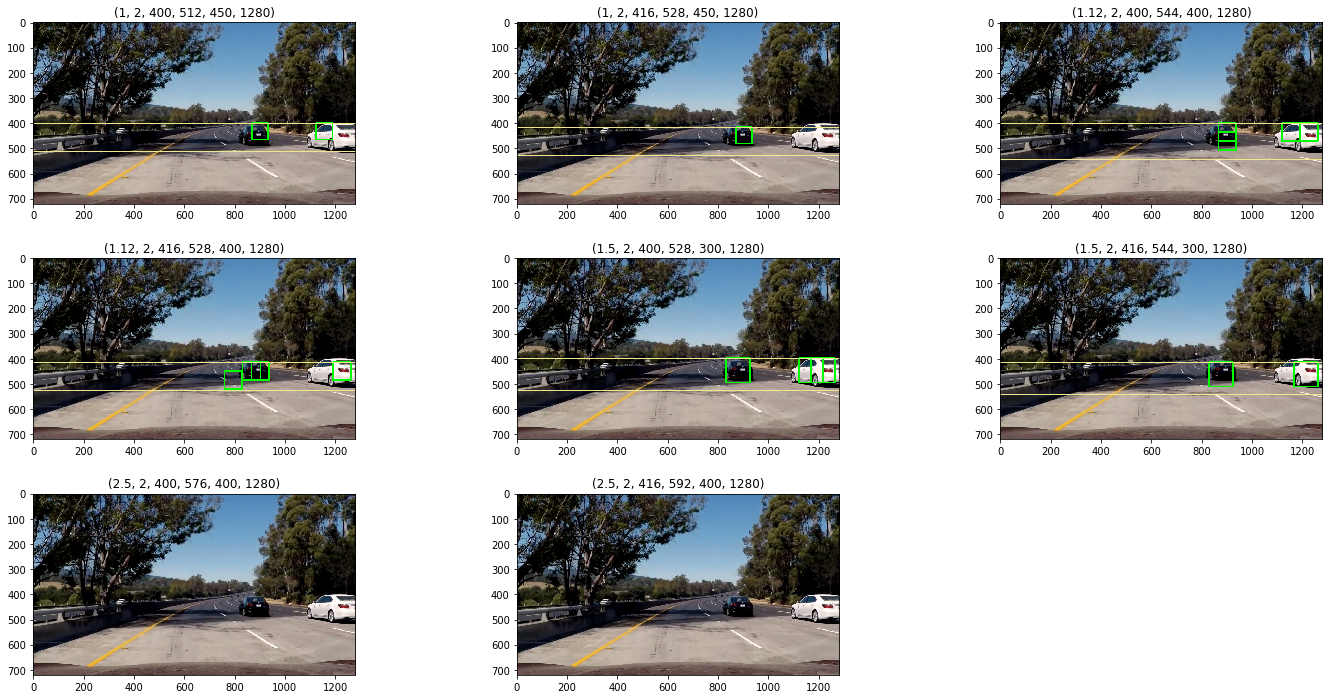

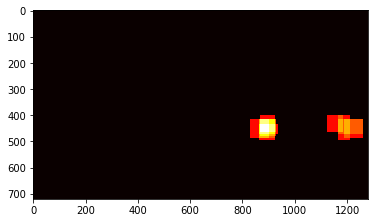

CPU times: user 2.21 s, sys: 1.23 s, total: 3.45 s
Wall time: 1.98 s


In [160]:
for img_path in (ROOT_PATH/'images/test_images').glob('*jpg'):
    print(img_path)
    img = read_image(img_path.as_posix())
    %time car_detector.draw_detect_boxes(img)

## Pipeline on video

In [161]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

VIDEO_INPUT_PATH = Path(ROOT_PATH)/'videos/test_videos'
VIDEO_OUTPUT_PATH = Path(ROOT_PATH)/'videos/test_videos_result'

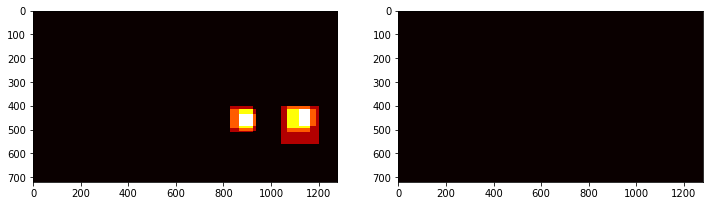

[MoviePy] >>>> Building video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/test_video_result_subsample_ver3.mp4
[MoviePy] Writing video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/test_video_result_subsample_ver3.mp4


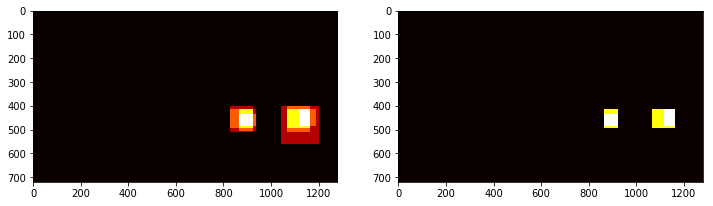

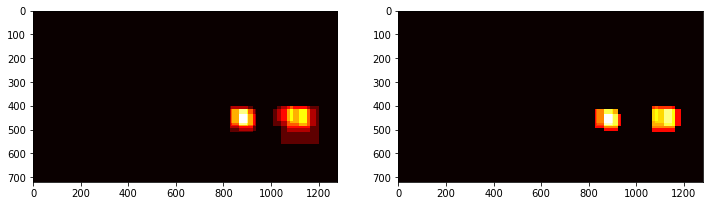

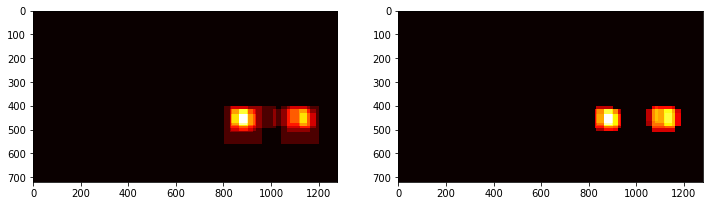

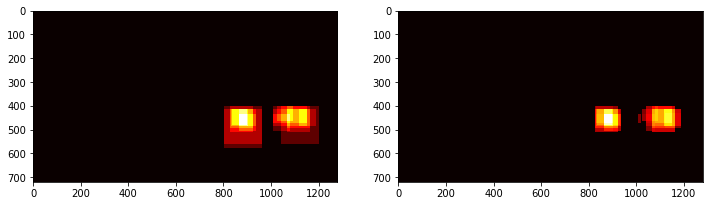

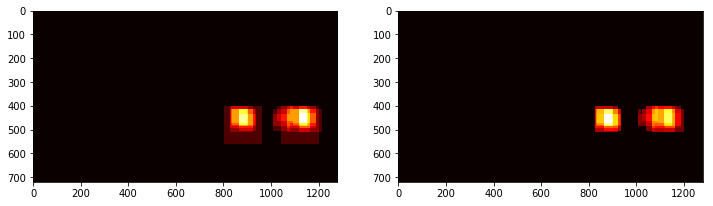

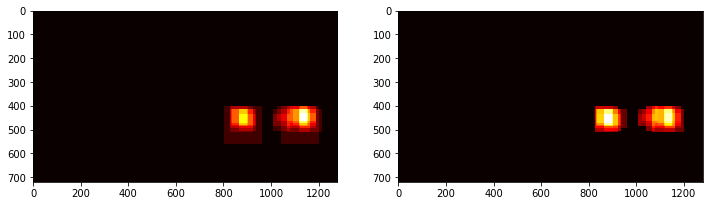

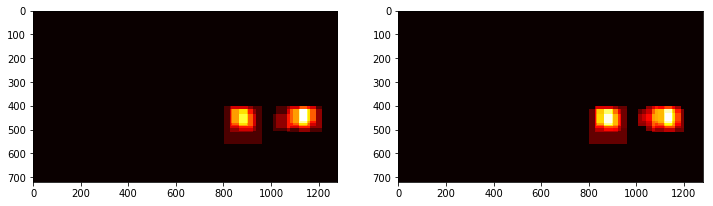

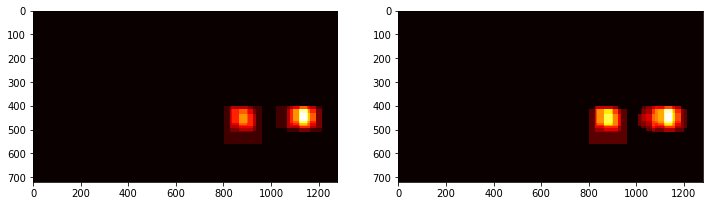

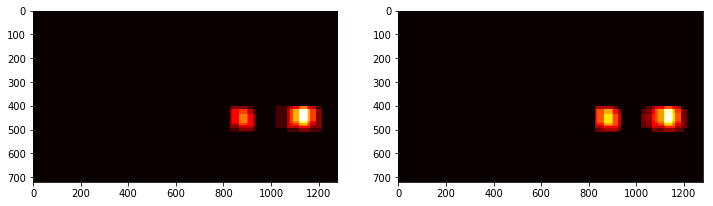

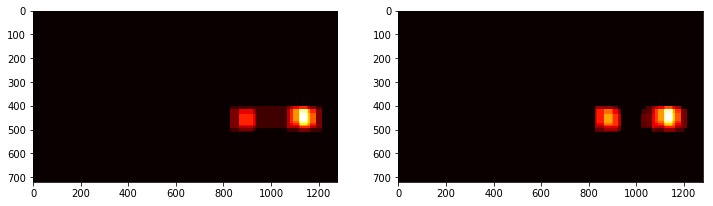

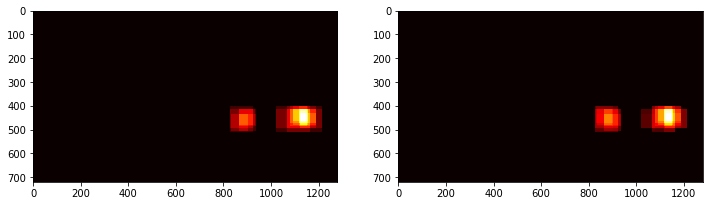

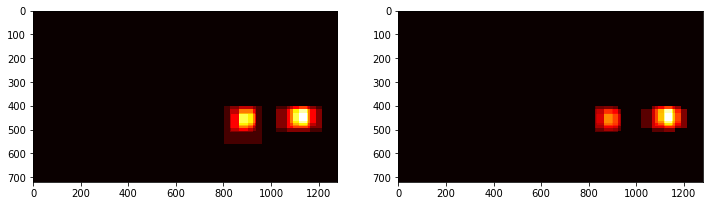

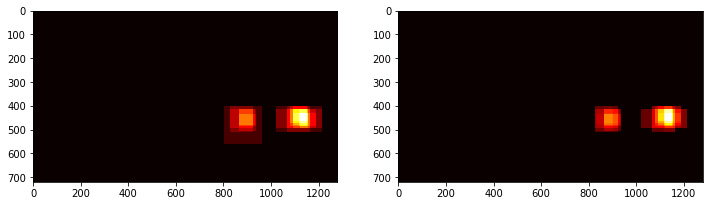

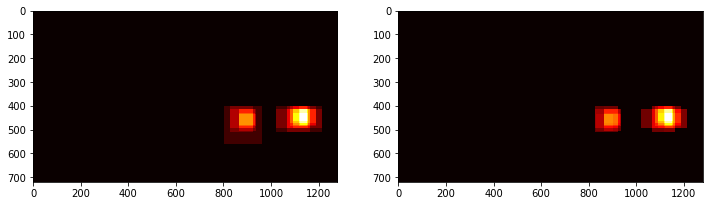

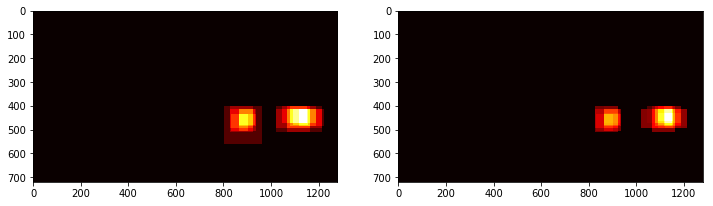

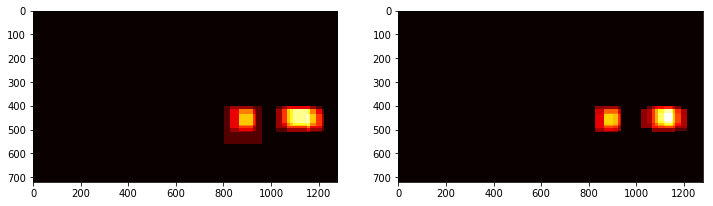

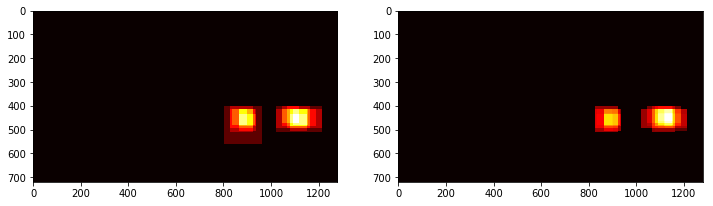

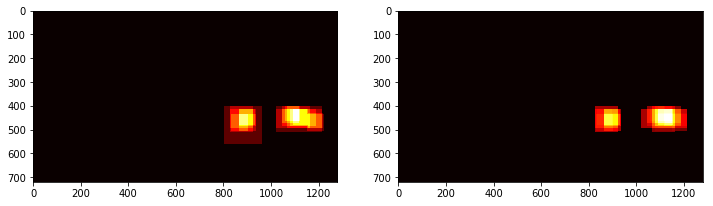

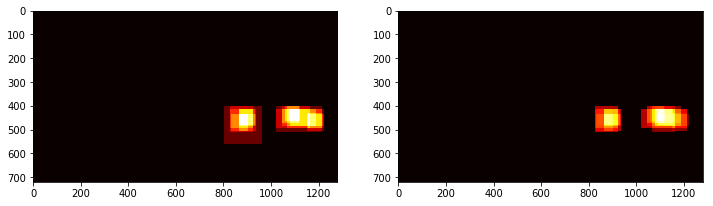

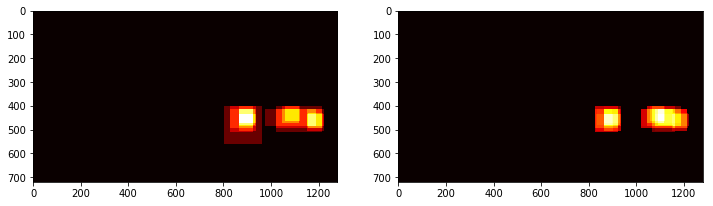

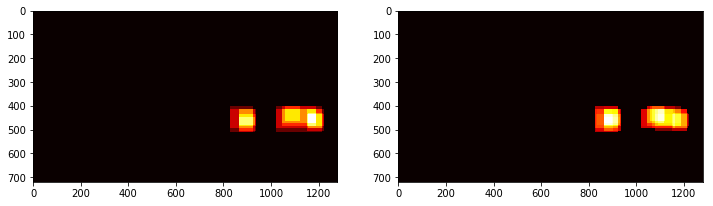

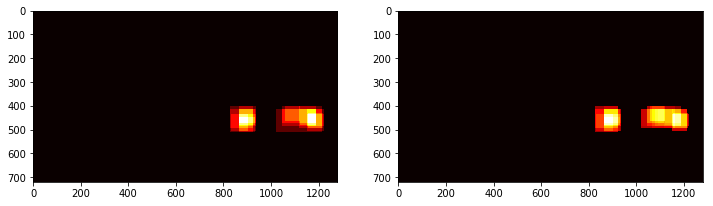

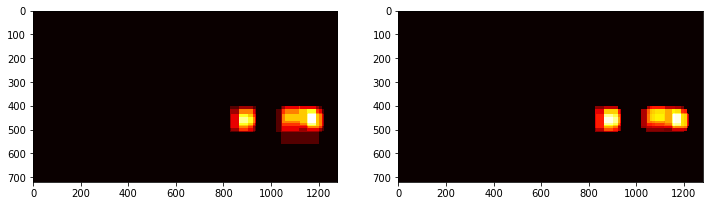

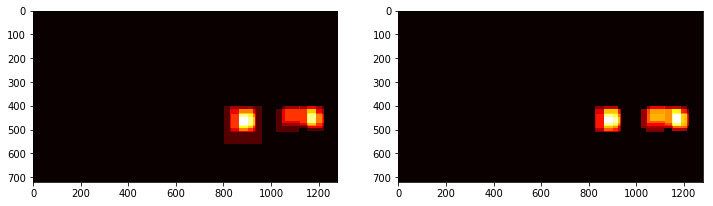

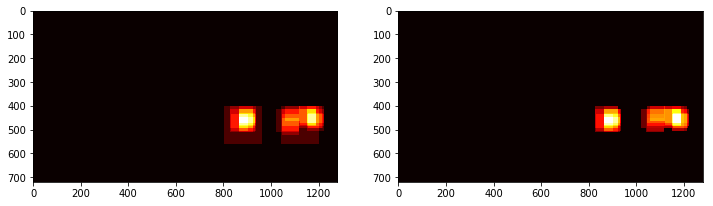

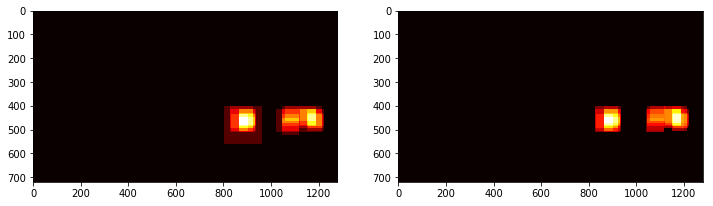

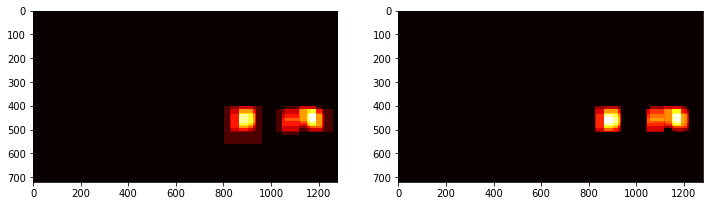

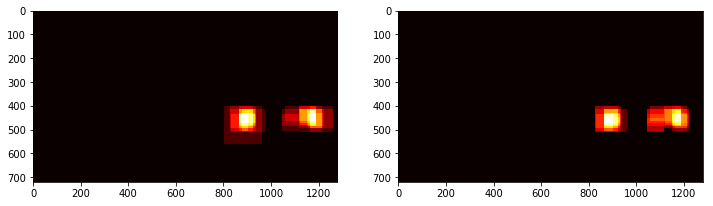

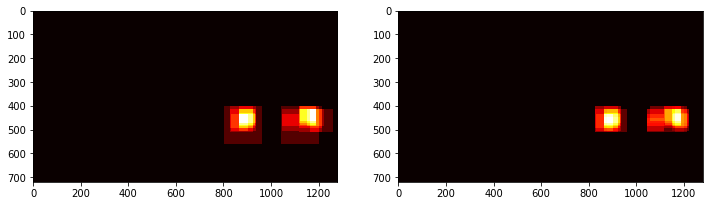

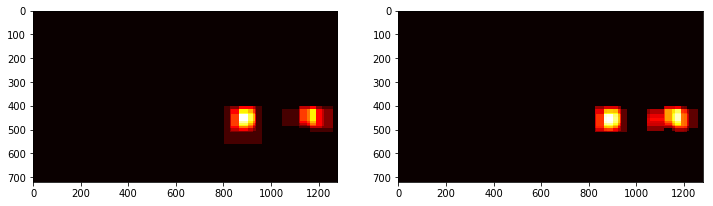

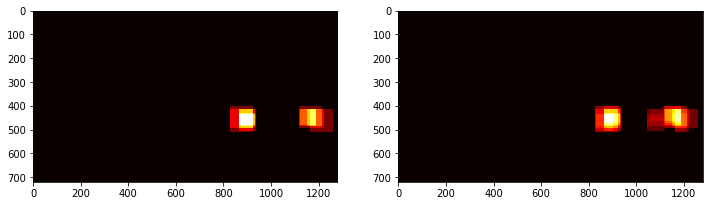

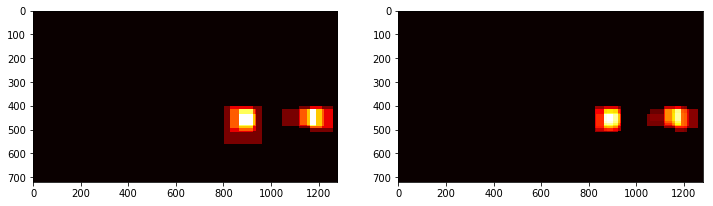

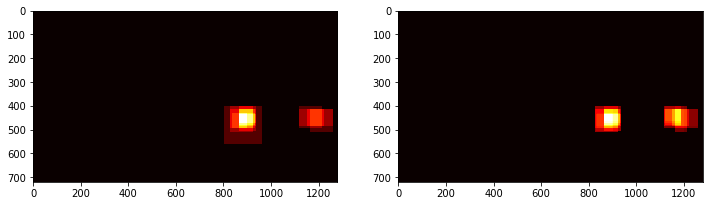

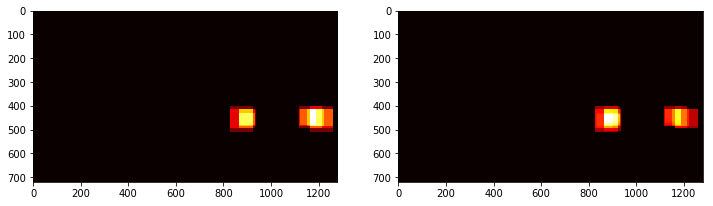

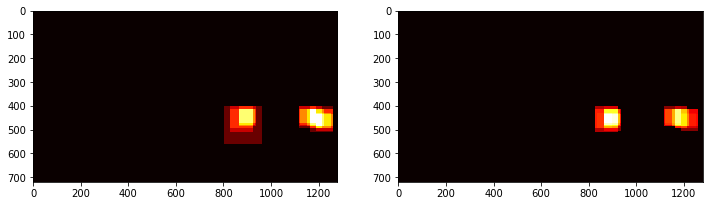

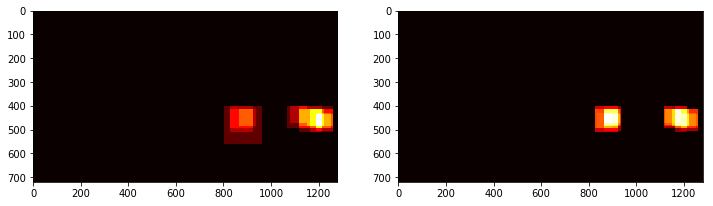

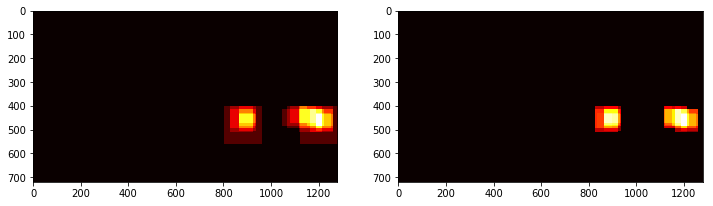

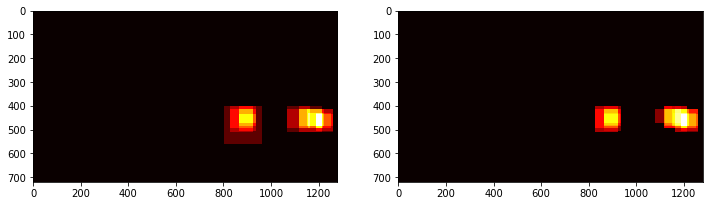

[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/test_video_result_subsample_ver3.mp4 

CPU times: user 22.6 s, sys: 18.4 s, total: 41.1 s
Wall time: 21.3 s


In [163]:
threshold = 5
num_records = 5
car_detector = CarDetector(scales, threshold, classifier=svc, scaler=None, cspace=cspace, orient=orient,
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, num_records=num_records, diagnosis=True)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'test_video.mp4').as_posix())
white_clip = clip1.fl_image(car_detector.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'test_video_result_subsample_ver3.mp4').as_posix(), audio=False, progress_bar=False)

In [165]:
%%time
threshold = 8
num_records = 9

car_detector = CarDetector(scales, threshold, classifier=svc, scaler=None, cspace=cspace, orient=orient,
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, num_records=num_records, diagnosis=False)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'project_video.mp4').as_posix())
white_clip = clip1.fl_image(car_detector.process) #NOTE: this function expects color images!!
white_clip.write_videofile((VIDEO_OUTPUT_PATH/'project_video_result_subsample_hog_ver3.mp4').as_posix(), audio=False, progress_bar=True)

[MoviePy] >>>> Building video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/project_video_result_subsample_hog_ver3.mp4
[MoviePy] Writing video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/project_video_result_subsample_hog_ver3.mp4


100%|█████████▉| 1260/1261 [05:59<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/project_video_result_subsample_hog_ver3.mp4 

CPU times: user 5min 51s, sys: 1min 30s, total: 7min 22s
Wall time: 6min
